# Machine Learning - Assignment 1

Arne Huckemann (ahuckema), Elise Wolf (eliwolf)

In [45]:
%matplotlib widget

In [46]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from mnist import MNIST  # run from Anaconda shell: pip install python-mnist
import sklearn
import sklearn.metrics
from sklearn.model_selection import KFold

# setup plotting 
from IPython import get_ipython
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")
def nextplot():
    if inTerminal:
        plt.clf()     # this clears the current plot
    else:
        plt.figure()  # this creates a new plot 

# Load the data

In [47]:
# not randomized
mndata = MNIST("data/")
X, y = mndata.load_training()
y = np.array(y, dtype="uint8")
X = np.array([np.array(x) for x in X], dtype="uint8")
N, D = X.shape
Xtest, ytest = mndata.load_testing()
ytest = np.array(ytest, dtype="uint8")
Xtest = np.array([np.array(x) for x in Xtest], dtype="uint8")
Ntest = Xtest.shape[0]

print(X.shape, y.shape, Xtest.shape, ytest.shape)
print(N, D, Ntest)

(60000, 784) (60000,) (10000, 784) (10000,)
60000 784 10000


In [48]:
# Optional: use a smaller sample of the data

# Randomized
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y == c)[0], size=100, replace=False))
X_s = X[p, :]
y_s = y[p]
N_s = X_s.shape[0]
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(ytest == c)[0], size=10, replace=False))
Xtest_s = Xtest[p, :]
ytest_s = ytest[p]
Ntest_s = Xtest_s.shape[0]

In [49]:
def showdigit(x):
    "Show one digit as a gray-scale image."
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap="gray")

5


/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_91973/1984499622.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()  # this creates a new plot


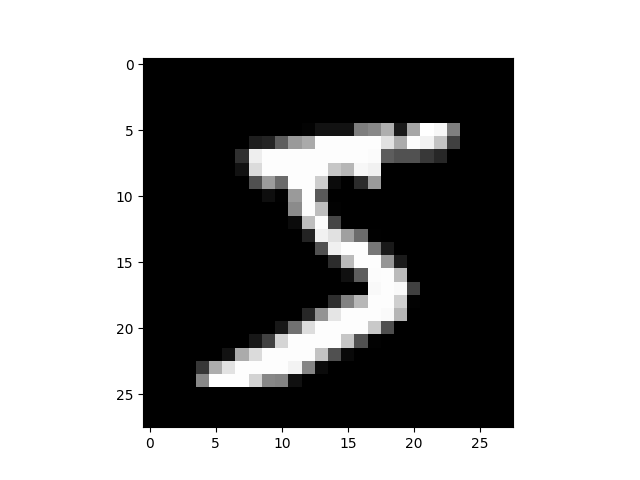

In [50]:
# Example: show first digit
nextplot()
showdigit(X[0,])
print(y[0])

In [51]:
def showdigits(X, y, max_digits=15):
    "Show up to max_digits random digits per class from X with class labels from y."
    num_cols = min(max_digits, max(np.bincount(y)))
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(
                10, num_cols, c * num_cols + j + 1, aspect="equal"
            )
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(
                    X[ii[j],].reshape(28, 28),
                    norm=mpl.colors.Normalize(0, 255),
                    cmap="gray",
                )
            else:
                ax.axis("off")

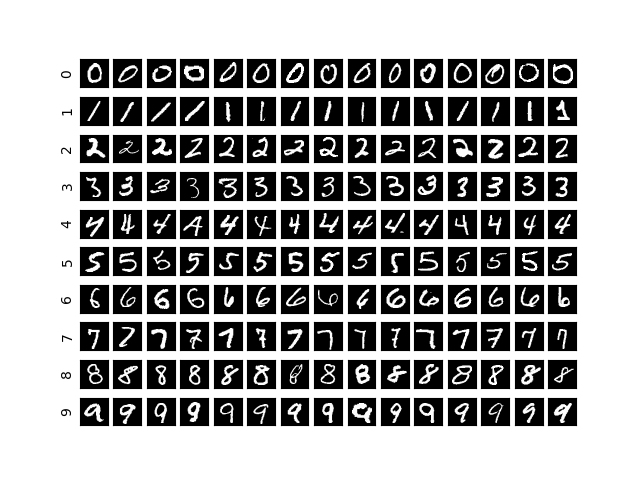

In [52]:
# Example: show 15 random digits per class from training data
nextplot()
showdigits(X, y)

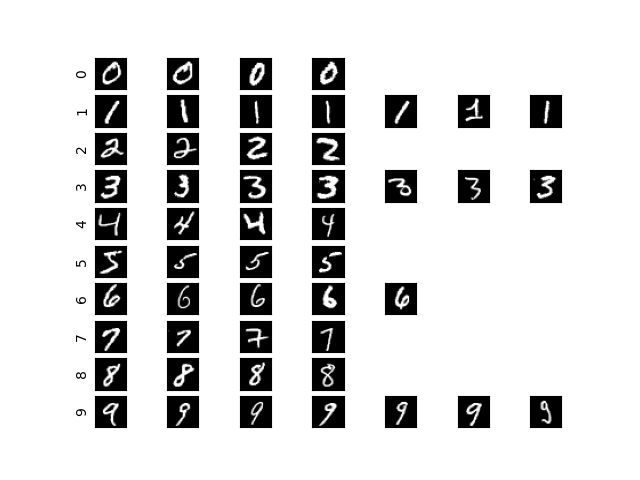

In [53]:
# Example: show a specific set of digits
nextplot()
showdigits(X[0:50,], y[0:50])

In [54]:
# A simple example dataset that you can use for testing
Xex = np.array([1, 0, 0, 1, 1, 1, 2, 0]).reshape(4, 2)
yex = np.array([0, 1, 2, 0])

# 1 Training

In [55]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

# calculate map estimate for the dirichlet prior (count class labels (frequency), fill into formular for fixed alpha)
def nb_train(X, y, alpha=1, K=None, C=None):
    """Train a Naive Bayes model.

    We assume that all features are encoded as integers and have the same domain
    (set of possible values) from 0:(K-1). Similarly, class labels have domain
    0:(C-1).

    Parameters
    ----------
    X : ndarray of shape (N,D)
        Design matrix.
    y : ndarray of shape (N,)
        Class labels.
    alpha : int
        Parameter for symmetric Dirichlet prior (Laplace smoothing) for all
        fitted distributions.
    K : int
        Each feature takes values in [0,K-1]. None means auto-detect.
    C : int
        Each class label takes values in [0,C-1]. None means auto-detect.

    Returns
    -------
    A dictionary with the following keys and values:

    logpriors : ndarray of shape (C,)
        Log prior probabilities of each class such that logpriors[c] contains
        the log prior probability of class c.

    logcls : ndarray of shape(C,D,K)
        A class-by-feature-by-value array of class-conditional log-likelihoods
        such that logcls[c,j,v] contains the conditional log-likelihood of value
        v in feature j given class c.
    """

    #return to metrices: vector for multinomial distribution of class labels, matrix: every feature is multinomial distributed, each column multinomial distributed 
    
    
    N, D = X.shape
    if K is None:
        K = int(np.max(X)) + 1 # changed to int() because of overflow error 
    if C is None:
        C = int(np.max(y)) + 1 # hchanged to int() because of overflow error 

    # calculate dirichlet prior for each class through counting class labels (frequency) and utilizing MAP estimate formula
    priors = np.zeros(C) # create empty array with 10 zeros
    for c in range(C):
        priors[c] = (np.sum(y == c) + alpha - 1) / (N + C*alpha - C)
    
    # test
    # print(f"Priors: {priors}")
    # print(np.sum(priors))
    
    # Compute class-conditional densities in a class x feature x value array and store them in cls. P(X | y = c) ( equal to likelihood, "how likely is picture x with pixel v1, ..., v784 to be in class c")
    cls = np.zeros((C, D, K))
    for c in range(C): # for each class
        X_c = X[y == c] # get all samples that belong to class c: y == c
        for j in range(D): # for each feature of the 28*28 = 784 features
            counts = np.bincount(X_c[:, j], minlength=K)  # Count occurrences of each value of gray scale in feature j
            cls[c, j, :] = (counts + alpha - 1) / (X_c.shape[0] + K * alpha - K) # calculate the class-conditional density

            # test
            # if c == 0 and j == 0:  # Beispiel für die erste Klasse und das erste Feature
                # print(f"Class {c}, Feature {j}, Class-conditional densities: {cls[c, j, :]}")
                # print(f"Counts for Class 0, Feature 0: {counts}")  # Hier counts aus der Schleife drucken

    # Output result
    return dict(logpriors=np.log(priors), logcls=np.log(cls))

nb_train(X, y, alpha = 1, K = None, C = None)
    

/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_91973/483148264.py:77: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))


{'logpriors': array([-2.31550148, -2.18598795, -2.30960971, -2.28098669, -2.32927136,
        -2.40406426, -2.31634601, -2.25936597, -2.32773198, -2.31112142]),
 'logcls': array([[[  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         ...,
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf]],
 
        [[  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         ...,
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf]],
 
        [[  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         [  0., -inf, -inf, ..., -inf, -inf, -inf],
         ...,
 

In [56]:
# Test your code (there should be a warning when you run this)
model = nb_train(Xex, yex, alpha=1)
model
# This should produce:
# {'logcls': array([[[       -inf, -0.69314718, -0.69314718],
#          [ 0.        ,        -inf,        -inf]],
#
#         [[ 0.        ,        -inf,        -inf],
#          [       -inf,  0.        ,        -inf]],
#
#         [[       -inf,  0.        ,        -inf],
#          [       -inf,  0.        ,        -inf]]]),
#  'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_91973/483148264.py:77: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))


{'logpriors': array([-0.69314718, -1.38629436, -1.38629436]),
 'logcls': array([[[       -inf, -0.69314718, -0.69314718],
         [ 0.        ,        -inf,        -inf]],
 
        [[ 0.        ,        -inf,        -inf],
         [       -inf,  0.        ,        -inf]],
 
        [[       -inf,  0.        ,        -inf],
         [       -inf,  0.        ,        -inf]]])}

In [57]:
# Test your code (this time no warning)
model = nb_train(Xex, yex, alpha=2)  # here we use add-one smoothing
model
# This should produce:
# {'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
#          [-0.51082562, -1.60943791, -1.60943791]],
#
#         [[-0.69314718, -1.38629436, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]],
#
#         [[-1.38629436, -0.69314718, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]]]),
#  'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

{'logpriors': array([-0.84729786, -1.25276297, -1.25276297]),
 'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
         [-0.51082562, -1.60943791, -1.60943791]],
 
        [[-0.69314718, -1.38629436, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]],
 
        [[-1.38629436, -0.69314718, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]]])}

# 2 Prediction

In [58]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each column.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

In [59]:
def nb_predict(model, Xnew):
    """Predict using a Naive Bayes model.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    Xnew : nd_array of shape (Nnew,D)
        New data to predict.

    Returns
    -------
    A dictionary with the following keys and values:

    yhat : nd_array of shape (Nnew,)
        Predicted label for each new data point.

    logprob : nd_array of shape (Nnew,)
        Log-probability of the label predicted for each new data point.
    """
    logpriors = model["logpriors"]
    logcls = model["logcls"]
    Nnew = Xnew.shape[0]
    C, D, K = logcls.shape

    # Compute the unnormalized log joint probabilities P(Y=c, x_i) of each
    # test point (row i) and each class (column c); store in logjoint
    logjoint = np.zeros((Nnew, C))
    #yhat = np.zeros(Nnew, dtype="int")
    # YOUR CODE HERE

    # for all data points xi, for all classes c calculate the log joint probability
    for i in range(Nnew):  # for each data point
        for c in range(C):  # for each class
            logjoint[i, c] = logpriors[c] + np.sum(logcls[c, np.arange(D), Xnew[i, :]])

    # Compute the logsumexp across classes for each test point (for normalization)
    logsum = logsumexp(logjoint.T)  # Transpose to sum over classes (axis 0)

    # Predicted labels: Take the class with the highest log joint probability
    yhat = np.argmax(logjoint, axis=1)

    # Log-probability of the predicted label (log likelihood of the best class)
    logprob = logjoint[np.arange(Nnew), yhat] - logsum    
    
    return dict(yhat=yhat, logprob=logprob)

In [60]:
# Test your code
model = nb_train(Xex, yex, alpha=2)
nb_predict(model, Xex)
# This should produce:
# {'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486]),
#  'yhat': array([0, 1, 2, 0], dtype=int64)}

{'yhat': array([0, 1, 2, 0]),
 'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486])}

In [61]:
# Test your code on full MNIST data
model = nb_train(X, y, alpha=2)

nb_predict(model, Xtest)

{'yhat': array([7, 2, 1, ..., 4, 5, 6]),
 'logprob': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.37250519e-02, -7.91260391e-10,  0.00000000e+00])}

# 3 Experiments on MNIST Digits Data

### 3.1 Model with add-one-smoothing

In [62]:
# Let's train the model on the digits data and predict
model_nb2 = nb_train(X, y, alpha=2)
pred_nb2 = nb_predict(model_nb2, Xtest)
yhat = pred_nb2["yhat"]
logprob = pred_nb2["logprob"]

In [63]:
# Accuracy
accuracy = sklearn.metrics.accuracy_score(ytest, yhat)
print("Accuracy:", accuracy)

# Precision
precision = sklearn.metrics.precision_score(ytest, yhat, average=None)
print("Precision:", precision)

# Recall
recall = sklearn.metrics.recall_score(ytest, yhat, average=None)
print("Recall:", recall)

# F1
f1 = sklearn.metrics.f1_score(ytest, yhat, average=None)
print("F1 Score:", f1)



Accuracy: 0.8363
Precision: [0.91022965 0.8609375  0.89375685 0.76605505 0.8244898  0.7757732
 0.8847352  0.91216931 0.79144943 0.75264085]
Recall: [0.88979592 0.97092511 0.79069767 0.82673267 0.82281059 0.67488789
 0.88935282 0.8385214  0.77926078 0.84737364]
F1 Score: [0.8998968  0.9126294  0.83907455 0.7952381  0.82364934 0.72182254
 0.887038   0.87379625 0.78530781 0.7972028 ]


Text(0.5, 0.98, 'Digits grouped by predicted label')

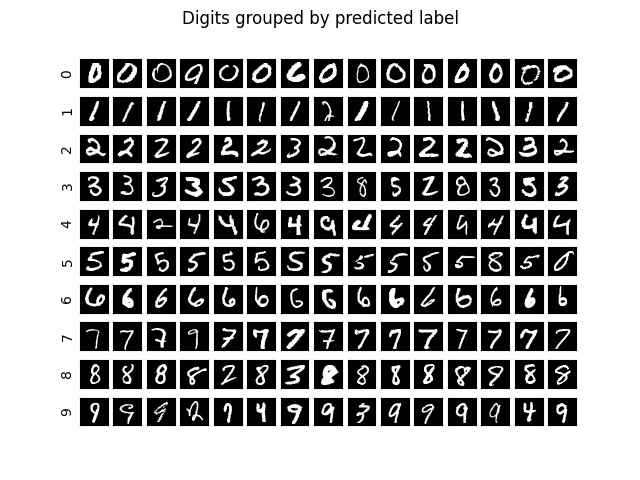

In [64]:
# show some digits grouped by prediction; can you spot errors?
nextplot()
showdigits(Xtest, yhat)
plt.suptitle("Digits grouped by predicted label")

Remark: on the left are given classes and errors that are classified as these specific classes are given on the right
prediction errors:
- 0 --> 4 or 2 
- 1 --> 2
- 2 --> 3 that looks like 2, 7 that looks like 2, 6 
- 4 --> often mistaken as 5, once also 6 and 4
- 5 --> often mistaken as 0 (pretty often), once also 8 and 9 (why 8 and 9)
- 6 --> 5
- 7 --> 8 and 3
- 8 --> 3 and 4 
- 9 -- often mistaken as 4, once also 8

Text(0.5, 0.98, 'Errors grouped by predicted label')

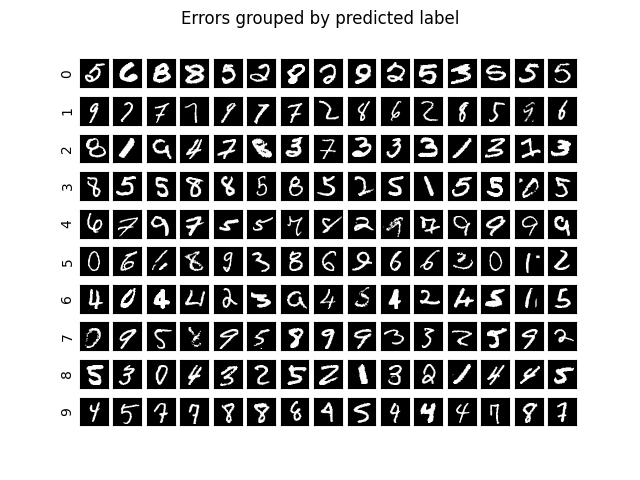

In [65]:
# do the same, but this time show wrong predicitions only
perror = ytest != yhat
nextplot()
showdigits(Xtest[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")

Remark: on the left are given classes and errors that are classified as these specific classes are given on the right
- 0 has often values of 5, 9, potentially those with a thicker round writing
- 1 has often values like 7, 8, those which are written thinner, more in a line
- 2 has some misclassifications of 6, also 7, a few of 9, 5, 3, that are those with a thicker line at the top right circle of the number 2
- 3 has errors of 5, 6 and 8, especially those with a thick lower circle of number 3
- 4  pretty often misclassified with number two and 5 that has line on top of 5 or thick line on bottom of 2
- 5 misclassified as 8, 0. often winkel of first curve of 8 (left to right bottom) looks like main part of 5
- 6 misclassified with 4, 8, 0. often those with a round lower part, a "cross" in the middle of the number
- 7 has often values of 3 and 9, those with a top that look quite squeezed together
- 8 has values of 2, 5, 1, that have a thick top part
- 9 has errors 7, 3, 8, 4, thise that somehow cross in the middle of the number

Text(0.5, 0.98, 'Errors grouped by predicted label')

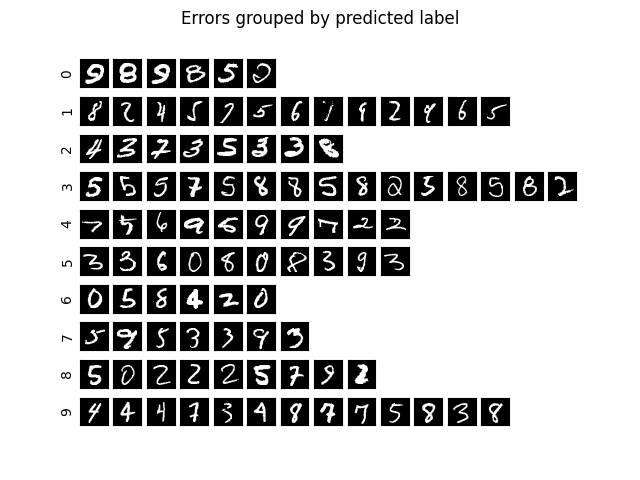

In [66]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
nextplot()
showdigits(Xtest[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")

Remark: it are given numbers of classes and which other error values they contain. Misclassification especially often for  1, 3, 4, 8 and 9, where
- 9 is mistaken as 4, 
- 8 is mistaken as 3
- 3 is mistaken as 5
- 4 is mistaken as everything 
- 1 is mistaken as 2 and 8

In [67]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(ytest, yhat))
print(sklearn.metrics.confusion_matrix(ytest, yhat))  # true x predicted

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.86      0.97      0.91      1135
           2       0.89      0.79      0.84      1032
           3       0.77      0.83      0.80      1010
           4       0.82      0.82      0.82       982
           5       0.78      0.67      0.72       892
           6       0.88      0.89      0.89       958
           7       0.91      0.84      0.87      1028
           8       0.79      0.78      0.79       974
           9       0.75      0.85      0.80      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000

[[ 872    0    3    5    3   63   18    1   14    1]
 [   0 1102    8    3    0    3    4    0   15    0]
 [  15   28  816   37   26    8   31   18   49    4]
 [   4   22   28  835    1   29   10   14   45   22]
 [   2    8    6    1  808   

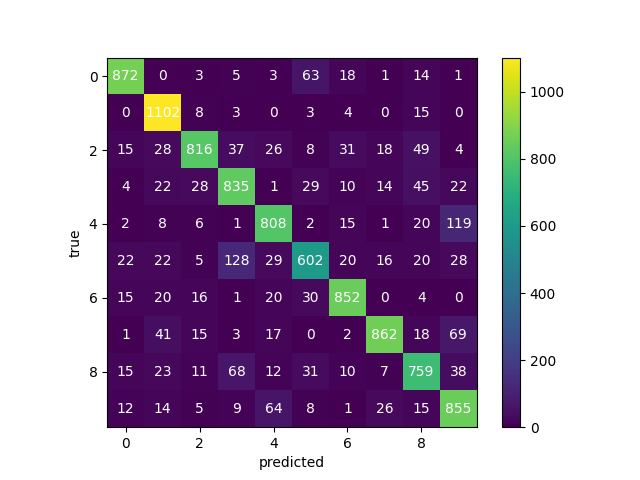

In [68]:
# plot the confusion matrix
nextplot()
M = sklearn.metrics.confusion_matrix(ytest, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()

0.9999999999822649
0.9999999996949782
0.9999999955447265
0.9999999478873192
0.999999302093004
0.9999908362580441
0.9998625944161882
0.9984220379937704
0.9859050917807745
0.8812574072789097


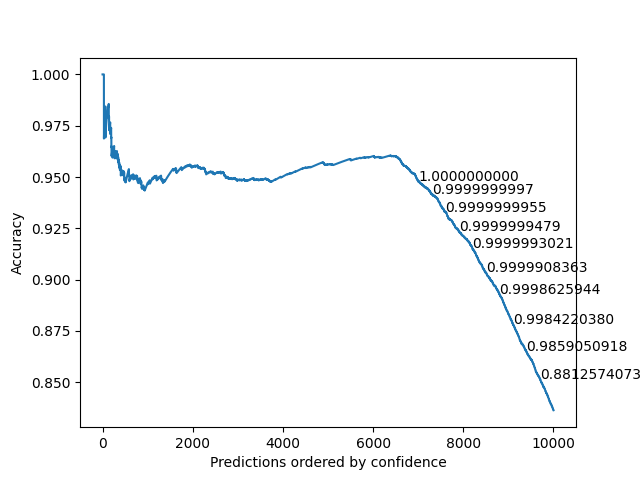

In [69]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(ytest[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot()
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))

Text(0, 0.5, 'Accuracy')

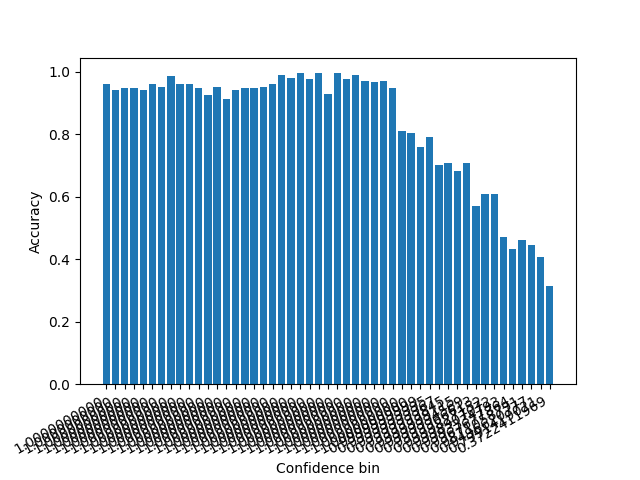

In [70]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 50) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(ytest[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
nextplot()
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)
plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

### 3.2 Model without add-one-smoothing

In [71]:
# Let's train the model on the digits data and predict
model_nb = nb_train(X, y, alpha=1)
pred_nb = nb_predict(model_nb, Xtest)
yhat = pred_nb["yhat"]
logprob = pred_nb["logprob"]

/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_91973/483148264.py:77: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_91973/2180804521.py:12: RuntimeWarning: invalid value encountered in subtract
  return offset + np.log(np.sum(np.exp(x - offset), axis=0))


In [72]:
# Accuracy
accuracy = sklearn.metrics.accuracy_score(ytest, yhat)
print("Accuracy:", accuracy)

# Precision
precision = sklearn.metrics.precision_score(ytest, yhat, average=None)
print("Precision:", precision)

# Recall
recall = sklearn.metrics.recall_score(ytest, yhat, average=None)
print("Recall:", recall)

# F1
f1 = sklearn.metrics.f1_score(ytest, yhat, average=None)
print("F1 Score:", f1)

# Confusion matrix - also plotted below
# cm = sklearn.metrics.confusion_matrix(ytest, yhat)
# ConfusionMatrixDisplay(cm).plot()


Accuracy: 0.4083
Precision: [0.1681138  0.9968254  0.63544304 0.65129151 0.77018634 0.37294333
 0.92696629 0.92084433 0.46634615 0.72260274]
Recall: [0.92857143 0.55330396 0.24321705 0.34950495 0.25254582 0.22869955
 0.34446764 0.33949416 0.39835729 0.41823588]
F1 Score: [0.28468638 0.71161473 0.35178697 0.45489691 0.3803681  0.28353023
 0.50228311 0.49609097 0.42967885 0.52981795]


Text(0.5, 0.98, 'Digits grouped by predicted label')

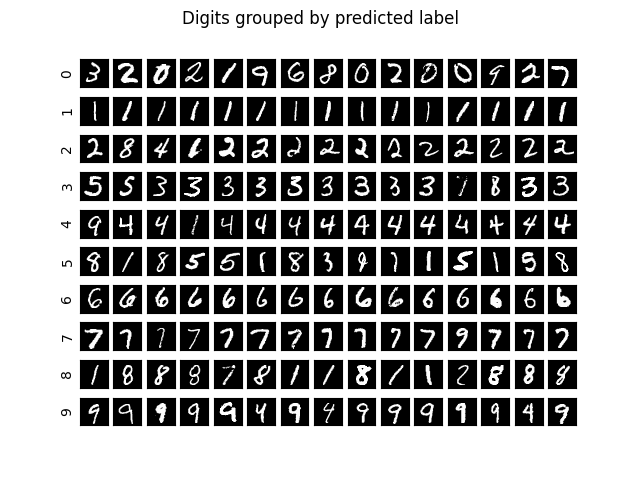

In [73]:
# show some digits grouped by prediction; can you spot errors?
nextplot()
showdigits(Xtest, yhat)
plt.suptitle("Digits grouped by predicted label")

Remark: on the left are given classes and errors that are classified as these specific classes are given on the right
predicted errors without add-one-smoothing:
- class 0 has almost only other (wrong) predicted handwritings
- class 1 is predicted right in this image
- class 2 has sometimes values of 1, 6 in it, also 0, 3, 5
- class 3 misclassified with 1, sometimes also 8, 4, 2
- class 5 misclassified with 4 pretty often, also 1, 4, 9
- class 6 predicted right in this image
- class 7 predicted right in this image
- class 8 misclassified with 1 pretty often, also 0, 4 one time
- class 9 misclassifications of 7, only few of 4

Text(0.5, 0.98, 'Errors grouped by predicted label')

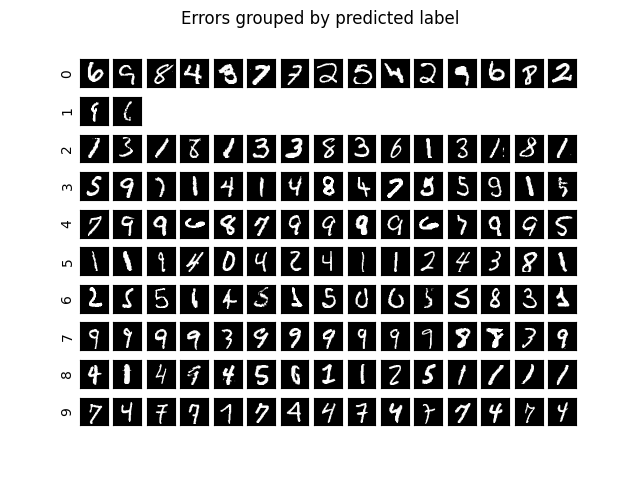

In [74]:
# do the same, but this time show wrong predicitions only
perror = ytest != yhat
nextplot()
showdigits(Xtest[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")

Remark: on the left are given classes and errors that are classified as these specific classes are given on the right
only wrong predicted errors without add-one-smoothing:
- 0 has 2, 3, 8 often in the wrong predicted labels, often those with a round part on the right
- 1 has only two errors of 9 and 6, both are written thin and squeezed together left and right to a stroke
- 2 has errors of 1, 0, 4, typically same curvy writing of the top part of number 2
- 3 has errors of 1, 5, 2, 4. thodse with a curvy bottom (2, 5) and thick stroke in the middle (1)
- 4 has often mispredicted 9's and 3 as well as 1, maybe due to stroke top to bottom
- 5 has wrong values 1, 4, 8. 4 looks similar in first written middle left corner of 5, 1 has same thickness
- 6 has 0, 2, 3, 5, pretty curvy all
- 7 has mispredicted 9, 2, 3, those which have diagonal strokes from top right to bottom left
- 8 has mispredicted 1, 7, maybe also due to diagnoal strokes
- 9 has errors of 4, 7, 1, often those that have remarkable horizontal line on top or somewhere in the middle and line on right from top to bottom

Text(0.5, 0.98, 'Errors grouped by predicted label')

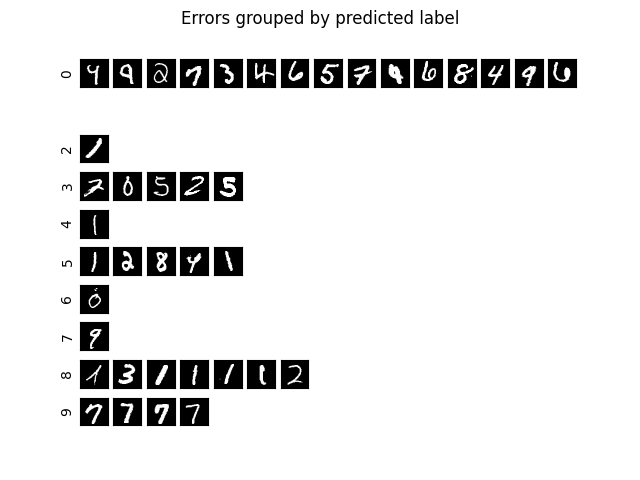

In [75]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
nextplot()
showdigits(Xtest[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")

there are only values given for 0, 2, 3, 7, 8, 9. 0 has the most (all 10 spaces filed), then comes 8, after that 5. 3 and 7 only have one error. 8 has pretty often the number 1 in its pictures and 0 has often pictures of 4, 5, 6.

In [76]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(ytest, yhat))
print(sklearn.metrics.confusion_matrix(ytest, yhat))  # true x predicted

              precision    recall  f1-score   support

           0       0.17      0.93      0.28       980
           1       1.00      0.55      0.71      1135
           2       0.64      0.24      0.35      1032
           3       0.65      0.35      0.45      1010
           4       0.77      0.25      0.38       982
           5       0.37      0.23      0.28       892
           6       0.93      0.34      0.50       958
           7       0.92      0.34      0.50      1028
           8       0.47      0.40      0.43       974
           9       0.72      0.42      0.53      1009

    accuracy                           0.41     10000
   macro avg       0.66      0.41      0.44     10000
weighted avg       0.67      0.41      0.45     10000

[[910   0   7   8   2  15   6   0  32   0]
 [ 73 628  63  43   5 129   5   1 184   4]
 [706   0 251  27   1  12   3   2  30   0]
 [533   0  29 353   4  40   2   5  35   9]
 [543   0   9  13 248  60   3   2  46  58]
 [580   0   5  38   5 204 

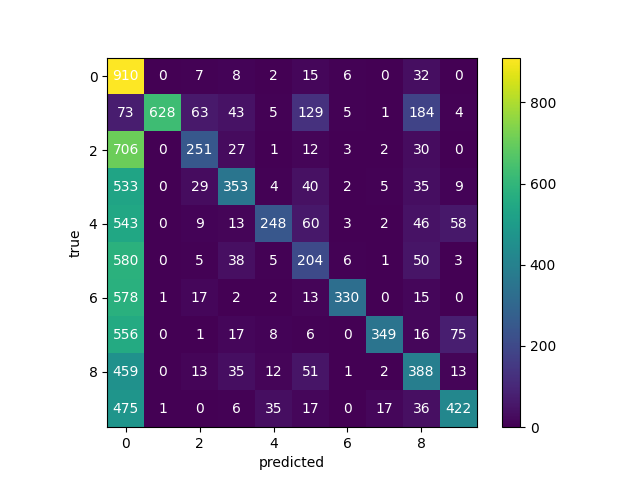

In [77]:
# plot the confusion matrix
nextplot()
M = sklearn.metrics.confusion_matrix(ytest, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999827196
0.9999912466323606


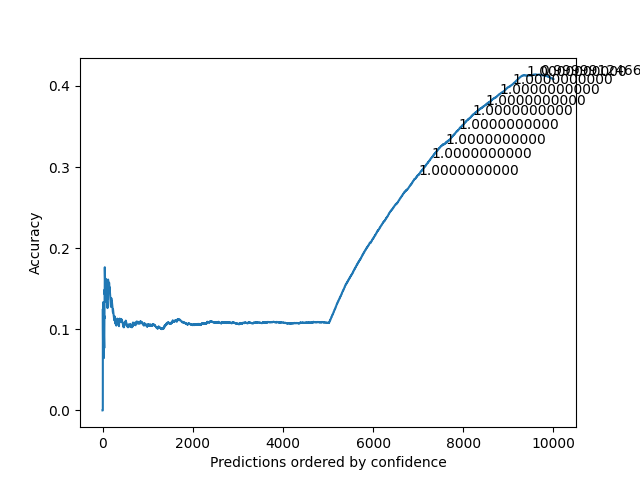

In [78]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(ytest[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot()
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))

Text(0, 0.5, 'Accuracy')

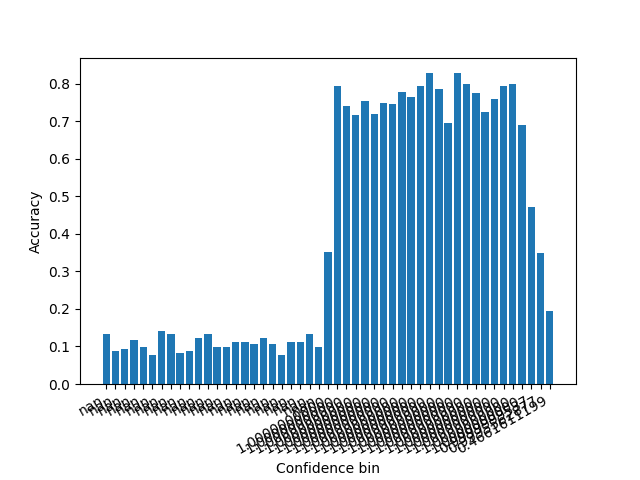

In [79]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 50) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(ytest[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
nextplot()
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)
plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

# 4 Model Selection (optional)

In [80]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

# Definiere einen Wrapper für den Naive Bayes Classifier mit einem alpha-Parameter
class NaiveBayesClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        # Trainiere das Modell mit dem gegebenen alpha
        self.model = nb_train(X, y, alpha=self.alpha)
        return self

    def predict(self, X):
        # Mache Vorhersagen
        return nb_predict(self.model, X)["yhat"]

In [87]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Definiere Alpha-Werte (mit feinerer Auflösung um Alpha=2)
alpha_values = [0.5, 1, 1.3, 1.5, 1.75, 2, 2.5, 3, 5, 1]

# To create folds, you can use:
K = 5
Kf = KFold(n_splits=K, shuffle=True)


# Um die Genauigkeiten für jedes Alpha zu speichern
accuracy_scores = []

for alpha in alpha_values:
    fold_accuracies = []
        
    for i_train, i_test in Kf.split(X):
        # code here is executed K times, once per test fold
        # i_train has the row indexes of X to be used for training
        # i_test has the row indexes of X to be used for testing

        # Split in Trainings- und Testdaten (Folds)
        X_train, X_val = X[i_train], X[i_test]
        y_train, y_val = y[i_train], y[i_test]

        # Trainiere das Modell mit dem aktuellen Alpha-Wert
        model = nb_train(X_train, y_train, alpha=alpha)
        
        # Mache Vorhersagen auf den Validierungsdaten
        predictions = nb_predict(model, X_val)["yhat"]
        
        # Berechne die Genauigkeit auf dem Validierungssatz
        accuracy = np.mean(predictions == y_val)
        fold_accuracies.append(accuracy)

        print(
        "Fold has {:d} training points and {:d} test points".format(
            len(i_train), len(i_test)
        )
    )

    # Durchschnittliche Genauigkeit über die Folds hinweg für das aktuelle Alpha
    avg_accuracy = np.mean(fold_accuracies)
    accuracy_scores.append(avg_accuracy)

    print(f"Alpha: {alpha}, Average Accuracy: {avg_accuracy:.4f}")

/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_91973/483148264.py:77: RuntimeWarning: invalid value encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))


Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Alpha: 0.5, Average Accuracy: 0.0782


/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_91973/483148264.py:77: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
/var/folders/qg/82ll9gvd1pd4329hnkdpf8ch0000gn/T/ipykernel_91973/2180804521.py:12: RuntimeWarning: invalid value encountered in subtract
  return offset + np.log(np.sum(np.exp(x - offset), axis=0))


Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Alpha: 1, Average Accuracy: 0.3041
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Alpha: 1.3, Average Accuracy: 0.8344
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Alpha: 1.5, Average Accuracy: 0.8315
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 te

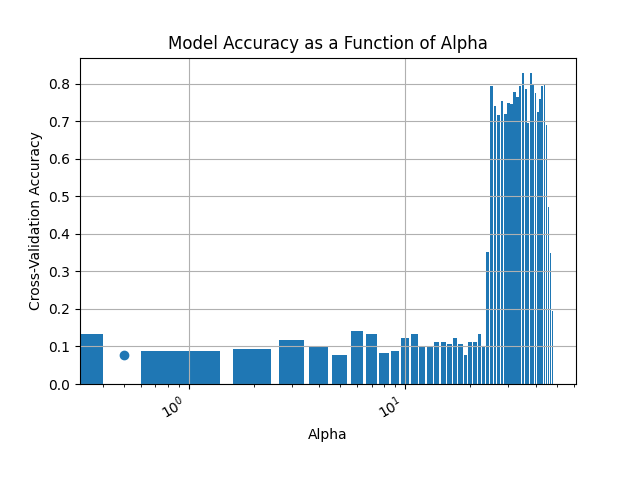

In [82]:
# Use cross-validation to find a good value of alpha. Also plot the obtained
# accuracy estimate (estimated from CV, i.e., without touching test data) as a
# function of alpha.
# YOUR CODE HERE

# Plot der Ergebnisse
plt.plot(alpha_values, accuracy_scores, marker='o')
plt.xscale('log')  # Logarithmische Skalierung für Alpha (da es große Unterschiede gibt)
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Accuracy as a Function of Alpha')
plt.grid(True)
plt.show()


# 5 Generating Data

In [83]:
def nb_generate(model, ygen):
    """Given a Naive Bayes model, generate some data.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    ygen : nd_array of shape (n,)
        Vector of class labels for which to generate data.

    Returns
    -------
    nd_array of shape (n,D)

    Generated data. The i-th row is a sampled data point for the i-th label in
    ygen.
    """
    logcls = model["logcls"]
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D))
    for i in range(n):
        c = ygen[i]
        # Generate the i-th example of class c, i.e., row Xgen[i,:]. To sample
        # from a categorical distribution with parameter theta (a probability
        # vector), you can use np.random.choice(range(K),p=theta).
        # YOUR CODE HERE

        for j in range(D):  # Für jedes Pixel j des Bildes
            # Wahrscheinlichkeiten für die Pixelwerte (den Grauwert)
            pixel_probs = np.exp(logcls[c, j, :])  # Umwandlung von Log-Wahrscheinlichkeiten in Wahrscheinlichkeiten
            pixel_probs /= np.sum(pixel_probs)  # Normierung auf Wahrscheinlichkeiten (Summe = 1)
            
            # Generiere den Pixelwert basierend auf der Wahrscheinlichkeitsverteilung
            Xgen[i, j] = np.random.choice(np.arange(K), p=pixel_probs)  # Wähle einen Pixelwert (0-255) basierend auf der Verteilung

    return Xgen

## 5.1 Model with alpha = 2

Text(0.5, 0.98, 'Some generated digits for each class')

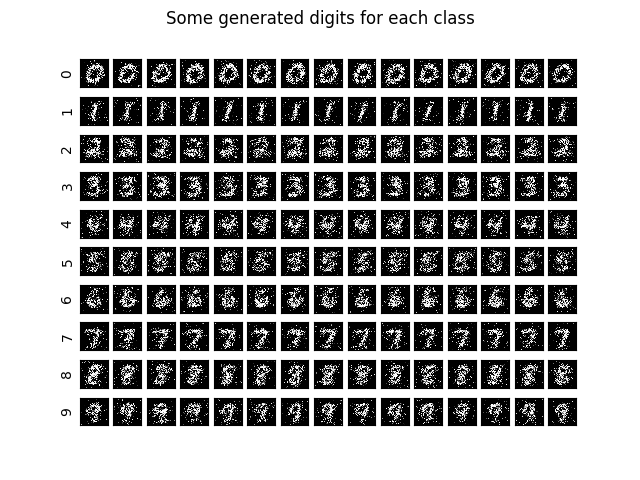

In [84]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb2, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

Text(0.5, 0.98, 'Most likely value of each feature per class')

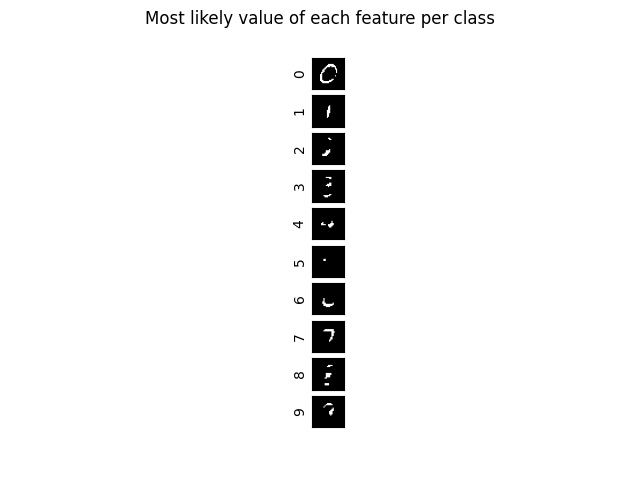

In [85]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb2["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

Text(0.5, 0.98, 'Expected value of each feature per class')

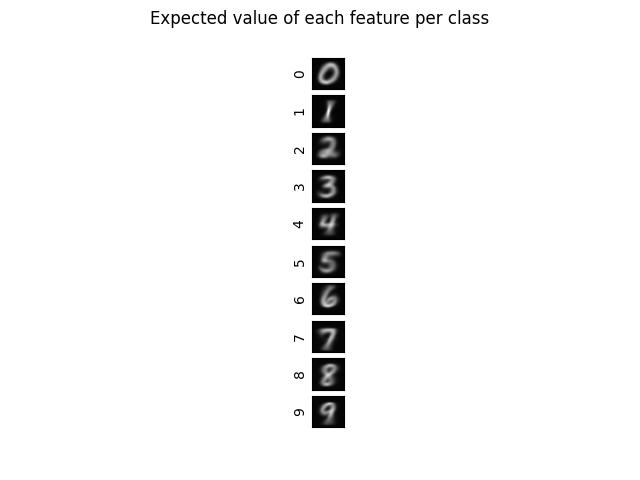

In [86]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb2["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")

## Model with alpha = 1

Text(0.5, 0.98, 'Some generated digits for each class')

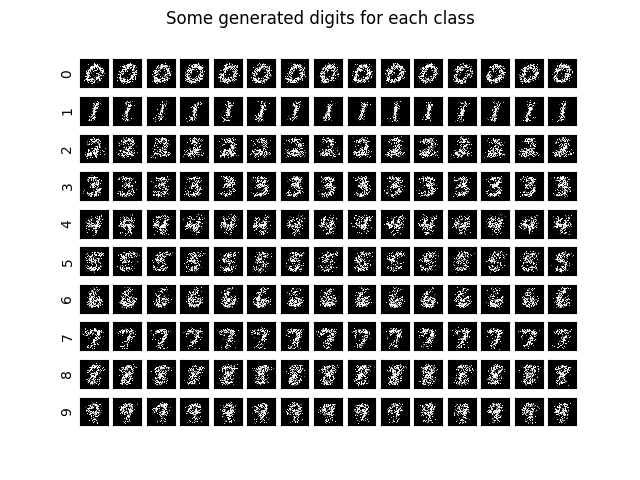

In [88]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

Text(0.5, 0.98, 'Most likely value of each feature per class')

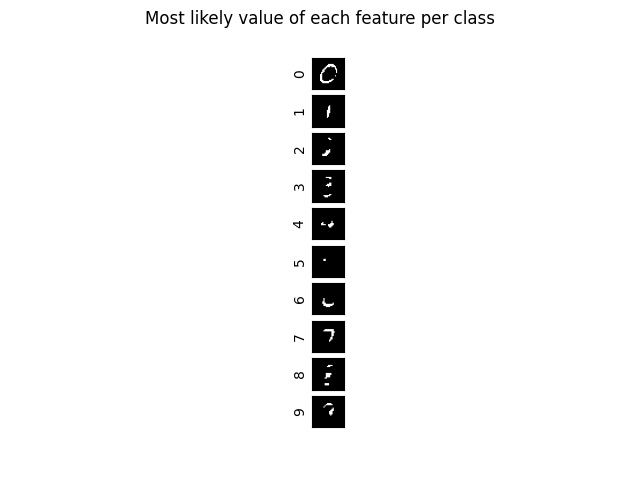

In [89]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

Text(0.5, 0.98, 'Expected value of each feature per class')

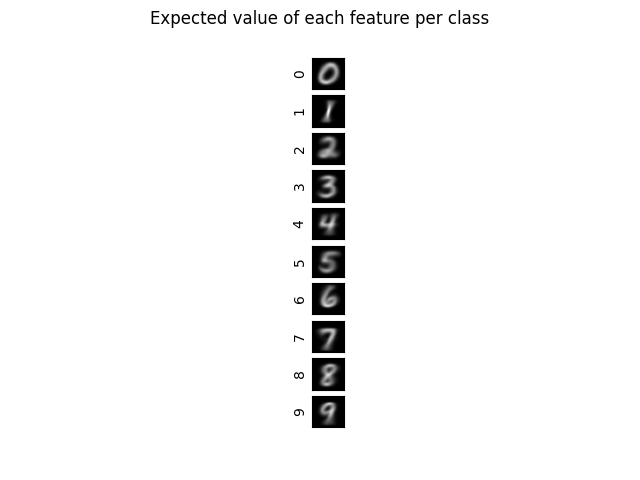

In [91]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")

## Model with optimal alpha = 1.3 of Task 4 

In [94]:
# Let's train the model on the digits data and predict
model_nb3 = nb_train(X, y, alpha=1.3)
pred_nb3 = nb_predict(model_nb3, Xtest)
yhat = pred_nb3["yhat"]
logprob = pred_nb3["logprob"]

Text(0.5, 0.98, 'Some generated digits for each class')

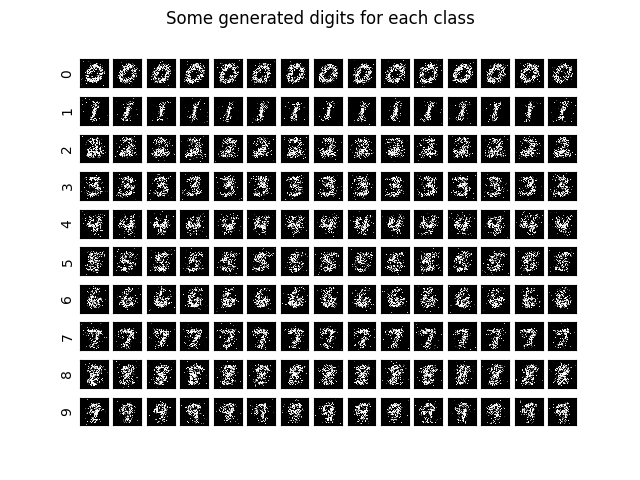

In [95]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb3, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

Text(0.5, 0.98, 'Most likely value of each feature per class')

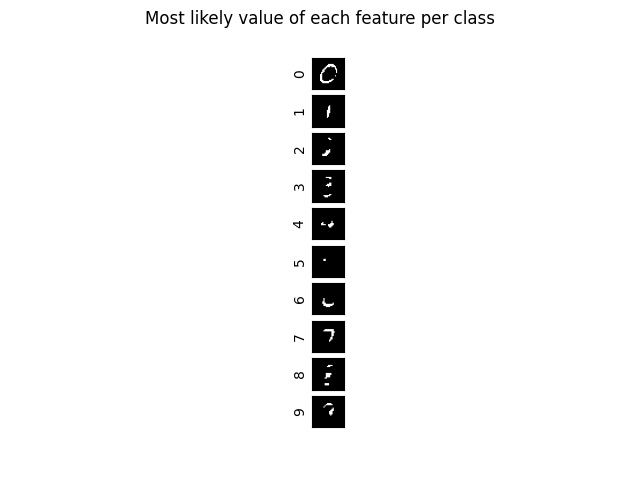

In [96]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb3["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

Text(0.5, 0.98, 'Expected value of each feature per class')

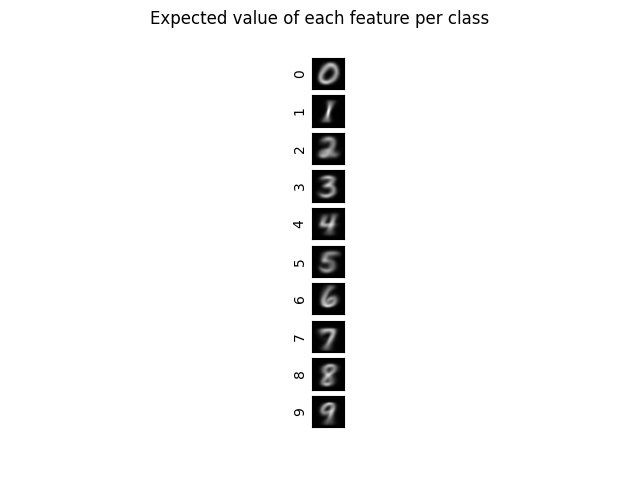

In [97]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb3["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")